# Assignment 1-1: K-Nearest Neighbors (k-NN)

In this notebook you will implement a K-Nearest Neighbors classifier on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Recall that the K-Nearest Neighbor classifier does the following:
- During training, the classifier simply memorizes the training data
- During testing, test images are compared to each training image; the predicted label is the majority vote among the K nearest training examples.

After implementing the K-Nearest Neighbor classifier, you will use *cross-validation* to find the best value of K.

The goals of this exercise are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/).

## Downloading the CIFAR-10 dataset 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data_utils
import download

In [2]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"
download.maybe_download_and_extract(url,download_dir)

Data has apparently already been downloaded and unpacked.


## Loading raw files and reading them as training and testing datasets

In [3]:
cifar10_dir = './data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)

# Checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Visualizing dataset samples
To give you a sense of the nature of the images in CIFAR-10, this cell visualizes some random examples from the training set.

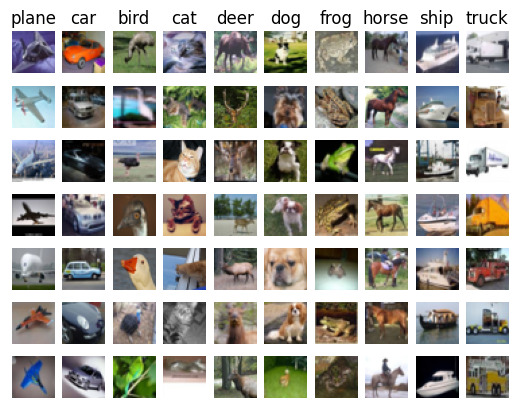

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Subsample the dataset
When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

We will subsample the data to use only 500 training examples and 250 test examples:

In [5]:
# Memory error prevention by subsampling data

num_training = 500
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 250
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(500, 3072) (250, 3072)


# K-Nearest Neighbors (k-NN)

Now that we have examined and prepared our data, it is time to implement the kNN classifier. We can break the process down into two steps:

1. Perform k-Nearest neighbours algorithm on the CiFAR-10 dataset to classify test images. 
2. Perform k-fold cross validation and plot the trend line with error bars that correspond to standard deviation to find the best value of the 'k' hyper parameter and best accuracy on the dataset.
3. Select the best value for k, and rerun the classifier on our full 5000 set of training examples.
4. Discussion: Discuss your understanding.

In [7]:
# Distance function
def compute_distances_two_loops(X_train, X_test):
    num_test = X_test.shape[0]
    num_train = X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
        for j in range(num_train):
            dists[i, j] = np.sqrt(np.sum((X_test[i] - X_train[j]) ** 2))
    return dists

# k-NN Classifier
def predict_labels(dists, y_train, k=1):
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
        closest_y = []
        sorted_indices = np.argsort(dists[i])
        closest_y = y_train[sorted_indices[:k]]
        y_pred[i] = np.argmax(np.bincount(closest_y))
    return y_pred

# Computing distances
dists = compute_distances_two_loops(X_train, X_test)

# Predicting labels
y_test_pred = predict_labels(dists, y_train, k=5)

# Computing accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print(f'Accuracy: {accuracy * 100}%')


Accuracy: 18.8%


In [9]:

# Define the distance function
def compute_distances(X_train, X_test):
    num_test = X_test.shape[0]
    num_train = X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
        dists[i] = np.sqrt(np.sum((X_train - X_test[i])**2, axis=1))
    return dists

# Define the function to predict labels
def predict_labels(dists, y_train, k=1):
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
        closest_y = []
        sorted_indices = np.argsort(dists[i])
        closest_y = y_train[sorted_indices[:k]]
        y_pred[i] = np.argmax(np.bincount(closest_y))
    return y_pred


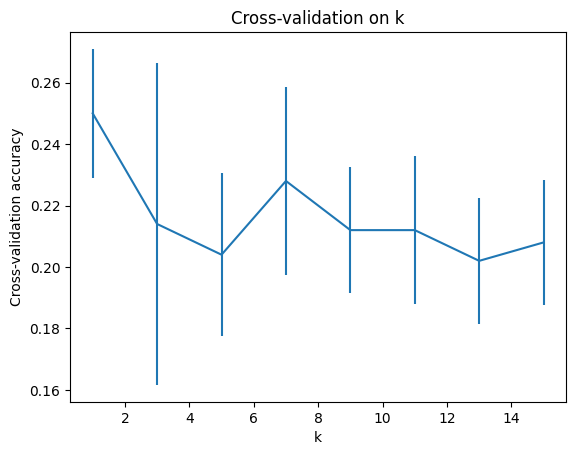

In [10]:
from sklearn.model_selection import KFold

def cross_validation(X_train, y_train, k_values, num_folds=5):
    kf = KFold(n_splits=num_folds)
    accuracy = np.zeros(len(k_values))
    accuracy_std = np.zeros(len(k_values))
    
    for idx, k in enumerate(k_values):
        fold_accuracies = []
        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            dists = compute_distances(X_train_fold, X_val_fold)
            y_val_pred = predict_labels(dists, y_train_fold, k)
            
            num_correct = np.sum(y_val_pred == y_val_fold)
            accuracy_fold = float(num_correct) / len(y_val_fold)
            fold_accuracies.append(accuracy_fold)
        
        accuracy[idx] = np.mean(fold_accuracies)
        accuracy_std[idx] = np.std(fold_accuracies)
    
    return accuracy, accuracy_std

# Define the range of k values to test
k_values = [1, 3, 5, 7, 9, 11, 13, 15]

# Perform cross-validation
accuracy, accuracy_std = cross_validation(X_train, y_train, k_values)

# Plot the results
plt.errorbar(k_values, accuracy, yerr=accuracy_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()


In [11]:
# Select the best k value
best_k = k_values[np.argmax(accuracy)]
print(f'Best k value: {best_k}')

# Rerun the classifier with the best k value on the full training set
dists = compute_distances(X_train, X_test)
y_test_pred = predict_labels(dists, y_train, best_k)

# Compute accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test)
print(f'Accuracy with best k: {accuracy * 100:.2f}%')


Best k value: 1
Accuracy with best k: 22.00%
